<a href="https://colab.research.google.com/github/fwangliberty/AIoTDesign-Frontend/blob/master/transfer_learning_using_pre_trained_mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
We are using tranfer learning for mobilenetv2 to train a neural network. First, we will use a pre-trained mobilenetv2 model with frozen trained weights (imagenet) and the top layers. Then, we free all weights and train the model again. As a result, it can give a very good accuracy (about 99%).  

## 1. Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mounted at /content/drive

In [2]:
!ls "/content/drive/My Drive/Garbage classification/"

cardboard  glass  metal  paper	plastic  trash


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Add, Reshape, DepthwiseConv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import glob, os, random
import numpy as np
import matplotlib.pyplot as plt

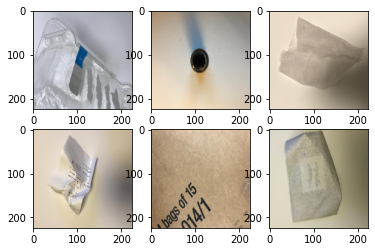

In [4]:
from keras.preprocessing import image
base_path = '/content/drive/My Drive/Garbage classification'
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

for i, img_path in enumerate(random.sample(img_list, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size= 32,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size= 32,
    class_mode='categorical',
    subset='validation',
    seed=0
)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [6]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 6))

In [7]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)



{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [8]:
!ls

drive  labels.txt  sample_data


In [9]:
path = 'labels.txt'
label = np.array(open(path).read().splitlines())

##2. Import MobileNetV2 

In [10]:
IMG_SHAPE = (224,224,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


### 2.1 Transfer learning with frozen weights

In [11]:
# Freeze all the layers before the `fine_tune_at` layer
base_model.trainable = False

for layer in  base_model.layers:
    print("{}: {}".format(layer, layer.trainable))

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f45e67645f8>: False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f461b0edb70>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45e64abf60>: False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f45e6461278>: False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f45e6461ef0>: False
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7f45e6461cf8>: False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f45e632c940>: False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f45e632cb00>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45e632cb38>: False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f45e6322550>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f

In [ ]:
#from tensorflow import keras
#model = tf.keras.Sequential([
#  base_model,
#  keras.layers.GlobalAveragePooling2D(),
#  keras.layers.Dense(6, activation='sigmoid')
#])

In [12]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.Dropout(0.9),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 256)         2949376   
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 256)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 1542      
Total params: 5,208,902
Trainable params: 2,950,918
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
#               loss='categorical_crossentropy', 
#               metrics=['accuracy'])

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), #RMSprop(lr=0.0001),  
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [16]:
batch_size = 32
epochs = 40
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit(train_generator, 
                    steps_per_epoch = steps_per_epoch,
                    epochs=epochs, 
                    validation_data=validation_generator, 
                    validation_steps=validation_steps)

Epoch 1/40
71/71 [==============================] - 30s 419ms/step - loss: 0.1986 - acc: 0.9229 - val_loss: 0.5083 - val_acc: 0.8482
Epoch 2/40
71/71 [==============================] - 30s 416ms/step - loss: 0.2350 - acc: 0.9111 - val_loss: 0.3849 - val_acc: 0.8571
Epoch 3/40
71/71 [==============================] - 29s 413ms/step - loss: 0.2133 - acc: 0.9234 - val_loss: 0.5124 - val_acc: 0.8482
Epoch 4/40
71/71 [==============================] - 29s 414ms/step - loss: 0.2417 - acc: 0.9202 - val_loss: 0.4892 - val_acc: 0.8304
Epoch 5/40
71/71 [==============================] - 29s 411ms/step - loss: 0.2445 - acc: 0.9109 - val_loss: 0.4117 - val_acc: 0.8661
Epoch 6/40
71/71 [==============================] - 29s 411ms/step - loss: 0.2017 - acc: 0.9260 - val_loss: 0.3986 - val_acc: 0.8750
Epoch 7/40
71/71 [==============================] - 29s 413ms/step - loss: 0.2534 - acc: 0.9140 - val_loss: 0.4997 - val_acc: 0.8304
Epoch 8/40
71/71 [==============================] - 29s 410ms/step - 

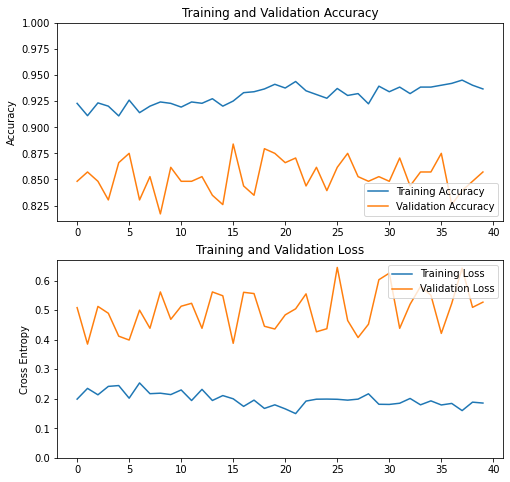

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

##3. Transfer Learning with trainable weights

In [18]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

for layer in  base_model.layers:
    print("{}: {}".format(layer, layer.trainable))

Number of layers in the base model:  155
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f45e67645f8>: True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f461b0edb70>: True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45e64abf60>: True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f45e6461278>: True
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f45e6461ef0>: True
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7f45e6461cf8>: True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f45e632c940>: True
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f45e632cb00>: True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45e632cb38>: True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f45e6322550>: True
<tensorflow.python.keras.layers.conv

In [ ]:
#model.compile(loss='binary_crossentropy',
 #             optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
  #            metrics=['accuracy'])
#model.summary()

In [21]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=2e-5),
              metrics=['accuracy'])

In [22]:
batch_size = 32
epochs = 50
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history_fine = model.fit(train_generator, 
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs, 
                                   workers=4,
                                   validation_data=validation_generator, 
                                   validation_steps=validation_steps) 

Epoch 1/50
71/71 [==============================] - 28s 389ms/step - loss: 0.0973 - accuracy: 0.9635 - val_loss: 0.8459 - val_accuracy: 0.8036
Epoch 2/50
71/71 [==============================] - 27s 382ms/step - loss: 0.0918 - accuracy: 0.9684 - val_loss: 0.6791 - val_accuracy: 0.8393
Epoch 3/50
71/71 [==============================] - 27s 375ms/step - loss: 0.0797 - accuracy: 0.9737 - val_loss: 0.7423 - val_accuracy: 0.8616
Epoch 4/50
71/71 [==============================] - 27s 377ms/step - loss: 0.0843 - accuracy: 0.9737 - val_loss: 0.7575 - val_accuracy: 0.8571
Epoch 5/50
71/71 [==============================] - 27s 376ms/step - loss: 0.0885 - accuracy: 0.9750 - val_loss: 0.5853 - val_accuracy: 0.8929
Epoch 6/50
71/71 [==============================] - 27s 377ms/step - loss: 0.0651 - accuracy: 0.9777 - val_loss: 0.5798 - val_accuracy: 0.8839
Epoch 7/50
71/71 [==============================] - 27s 382ms/step - loss: 0.0618 - accuracy: 0.9808 - val_loss: 0.5687 - val_accuracy: 0.8839

In [23]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

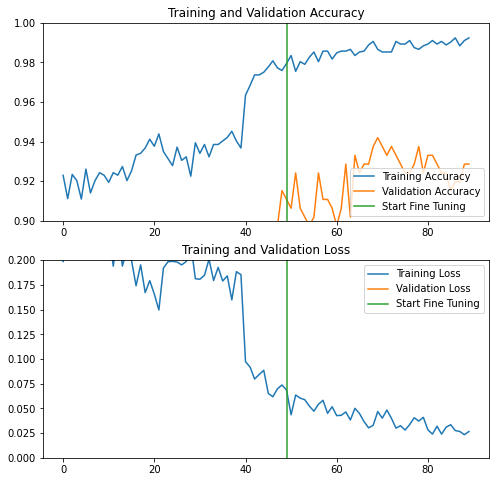

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save the model

In [26]:
model.save('mobilenetv2_grabage.h5')